In [1]:
%load_ext autoreload
%autoreload 2

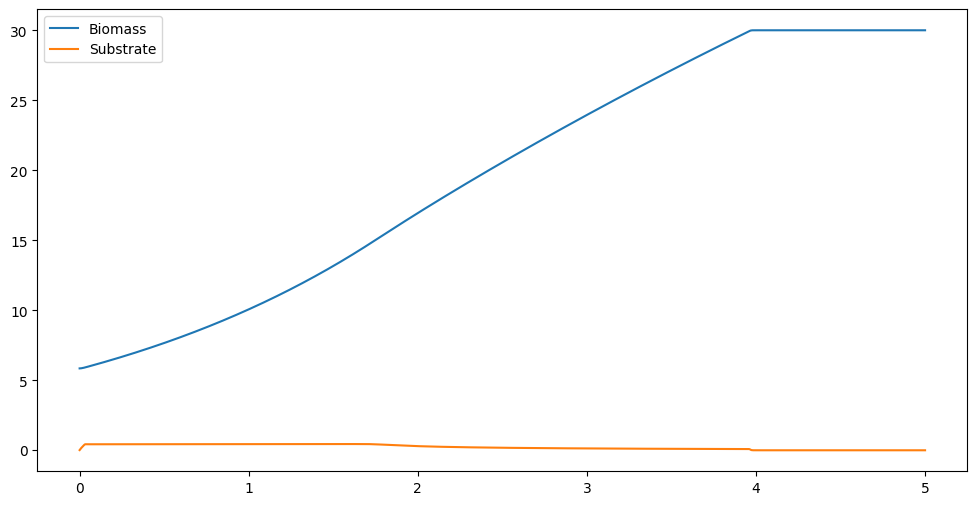

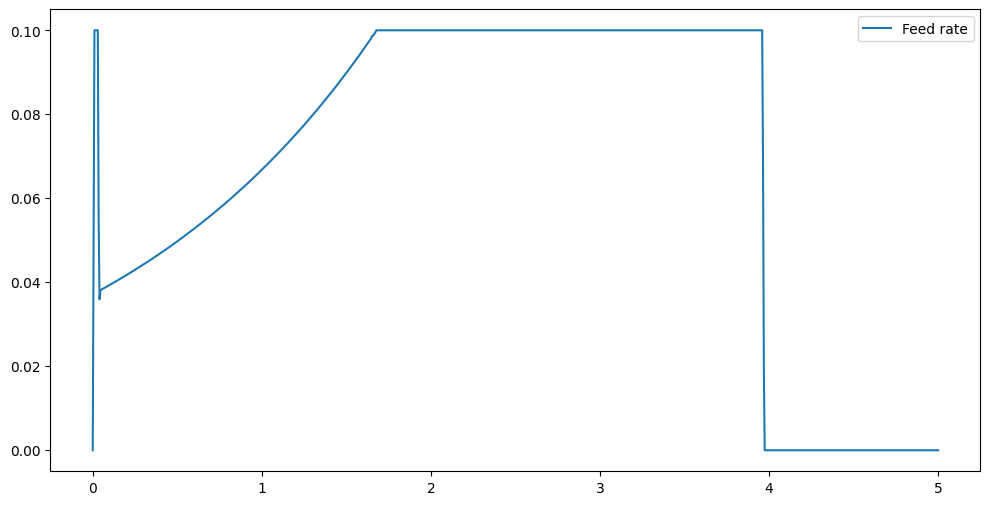

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from tqdm import tqdm


# ----- Constants -----
# Num of samples
NUM_SAMPLES = 1000

# Kinetic parameters
MU_MAX = 0.870       # 1/h
K_S    = 0.215       # g/l
Y_XS   = 0.496       # g/g
Y_PX   = 0.2         # g/g
S_F    = 1.43 * 200  # g/l

# Initial conditions
X_0 = 5.85
S_0 = 0.013
V_0 = 1.56

# Time parameters
T_START = 0
T_END = 5
TIME_RANGE = int(T_END - T_START) # Absolute time 
TIME = np.linspace(T_START, T_END, NUM_SAMPLES) # Time vector

# MPC parameters
dt = TIME[1] - TIME[0]                         # Time step
N_p = 3                          # Prediction horizon
Q = 1.5                          # Weight for tracking
Q_term = 0.0                     # Weight for terminal state
R = 0.1                            # Weight for control effort
OPTIMIZATION_METHOD = 'SLSQP' # Optimization method. Other options: 'SLSQP, 'L-BFGS-B', 'trust-constr', 'COBYLA', 'Powell', 'Nelder-Mead'

# Bounds for feeding rate
F_MIN = 0.0                  # l/h
F_MAX = 0.1                  # l/h
DELTA_F_MAX = 0.05           # Maximum change in feed rate
F_0 = (F_MAX - F_MIN) / 2    # Initial feed rate
BOUNDS = [(F_MIN, F_MAX) for _ in range(N_p)] 

# Constraints for volume and substrate concentration
V_MAX = 2.0  # Maximum volume
S_MAX = 2 # Maximum substrate concentration
w_S = 0.0    # Weight for substrate constraint
w_V = 0.0    # Weight for volume constraint

# Initial conditions
X = np.zeros_like(TIME)
S = np.zeros_like(TIME)
V = np.zeros_like(TIME)
F = np.zeros_like(TIME)
X[0], S[0], V[0] = X_0, S_0, V_0

# Setpoint
X_sp = 30

# ----- Bioreactor model -----
def dynamic_system(t, y, F):
    X, S, V = y
    dX_dt = (MU_MAX * S / (K_S + S)) * X - (F / V) * X
    dS_dt = -(1 / Y_XS) * (MU_MAX * S / (K_S + S)) * X + (F / V) * (S_F - S)
    dV_dt = F
    return np.array([dX_dt, dS_dt, dV_dt])


def discretized_model(t, X, S, V, F, h=0.01):
    k1 = dynamic_system(t, [X, S, V], F)
    k2 = dynamic_system(t + h / 2, [X + k1[0] * h / 2, S + k1[1] * h / 2, V + k1[2] * h / 2], F)
    k3 = dynamic_system(t + h / 2, [X + k2[0] * h / 2, S + k2[1] * h / 2, V + k2[2] * h / 2], F)
    k4 = dynamic_system(t + h, [X + k3[0] * h, S + k3[1] * h, V + k3[2] * h], F)

    X_next = X + (h / 6) * (k1[0] + 2 * k2[0] + 2 * k3[0] + k4[0])
    S_next = S + (h / 6) * (k1[1] + 2 * k2[1] + 2 * k3[1] + k4[1])
    V_next = V + (h / 6) * (k1[2] + 2 * k2[2] + 2 * k3[2] + k4[2])
    return X_next, S_next, V_next


# Cost function
def objective(F_seq, X_curr, S_curr, V_curr):
    X_pred, S_pred, V_pred = X_curr, S_curr, V_curr
    cost = 0
    F_prev = F[i]
    for j in F_seq:
        X_pred, S_pred, V_pred = discretized_model(TIME[i], X_pred, S_pred, V_pred, j, h=dt)
        cost += Q * (X_pred - X_sp) ** 2 
        cost += R * (j - F_prev) ** 2
        F_prev = j
    return cost

for i in range(len(TIME)-1):
    res = minimize(objective, np.ones(N_p) * F[i], args=(X[i], S[i], V[i]), bounds=BOUNDS, method=OPTIMIZATION_METHOD)
    F_new = res.x[0]
    F[i+1] = F_new
    F[i + 1] = np.clip(F[i] + np.clip(F_new - F[i], -DELTA_F_MAX, DELTA_F_MAX), F_MIN, F_MAX)  # Enforce Δp ≤ 20
    X[i+1], S[i+1], V[i+1] = discretized_model(TIME[i], X[i], S[i], V[i], F_new, h=dt)
    
    
plt.figure(figsize=(12, 6))
plt.plot(TIME, X, label='Biomass')
plt.plot(TIME, S, label='Substrate')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(TIME, F, label='Feed rate')
plt.legend()
plt.show()
    
    


In [29]:
F

array([0.        , 0.05      , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.05467992, 0.035955  , 0.03792056,
       0.03826904, 0.03833891, 0.03844717, 0.03855402, 0.03867595,
       0.03878893, 0.03890367, 0.03900988, 0.03912909, 0.03924291,
       0.03936294, 0.03947082, 0.0395877 , 0.03970701, 0.03982419,
       0.03993357, 0.04005609, 0.04017782, 0.04028299, 0.04041298,
       0.04052757, 0.04064234, 0.0407718 , 0.04088189, 0.04100743,
       0.04112342, 0.04125185, 0.04135917, 0.0414908 , 0.04161001,
       0.04173111, 0.04185143, 0.04198113, 0.04209765, 0.04222248,
       0.04234999, 0.04247122, 0.04259761, 0.0427164 , 0.04284822,
       0.04297455, 0.04309777, 0.04322549, 0.04335086, 0.04348526,
       0.0436013 , 0.0437334 , 0.04386401, 0.04399782, 0.04411611,
       0.04425003, 0.04438394, 0.04450942, 0.04464102, 0.04476988,
       0.04490831, 0.04503529, 0.04517139, 0.04529277, 0.04544088,
       0.04556026, 0.04571087, 0.04583167, 0.04597606, 0.04609